In [22]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import heapq
import random

import os
source_dir = '/content/drive/MyDrive/sources'

from PIL import Image
material_dict = {}

for filename in os.listdir(source_dir):
    if filename.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')):
        filepath = os.path.join(source_dir, filename)
        key = os.path.splitext(filename)[0]
        img = Image.open(filepath)

        if img.mode != 'RGB':
            img = img.convert('RGB')
            print(f"♻️ 已转换: {filename} ({img.mode}→RGB)")

        material_dict[key] = {
            'image': img,
            'pixels': img.load()
        }
        print(f"source: {filename} size: {img.size}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
source: floor.jpg size: (800, 800)
source: block.jpeg size: (2048, 2048)
source: squre.JPG size: (1048, 1049)
source: textile.jpg size: (699, 451)
source: roof.jpg size: (306, 273)


1. floor
2. block
3. squre
4. textile
5. roof
sources:
name: floor


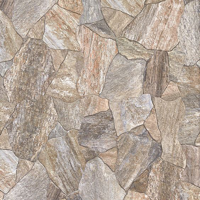

name: block


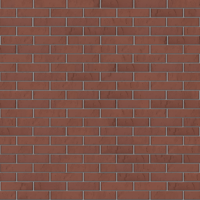

name: squre


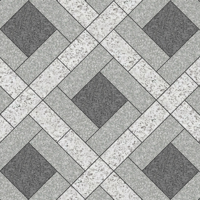

name: textile


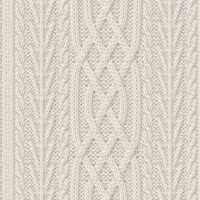

name: roof


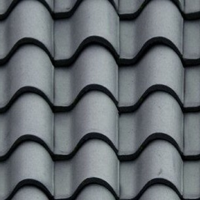

In [23]:
from IPython.display import display

for i, key in enumerate(material_dict.keys(), 1):
    print(f"{i}. {key}")

print("sources:")
for key, data in material_dict.items():
    print(f"name: {key}")
    display(data['image'].copy().resize((200, 200)))

In [24]:
def get_image(material_name):
    return material_dict[material_name]['image'].copy()

def get_pixels(material_name):
    return material_dict[material_name]['pixels']

def get_size(material_name):
    return material_dict[material_name]['image'].size

In [25]:
def show_5x5_patches_improved(image, boundary_coords, num_patches):
    img_array = np.array(image)
    print(f"size：{img_array.shape}")

    for i, (y, x) in enumerate(boundary_coords[:num_patches]):
        y = int(round(y))
        x = int(round(x))
        patch = img_array[max(0,y-2):y+3, max(0,x-2):x+3]

        print(f"\ncoord ({y}, {x}) 5X5 array：")
        print(patch.shape)

        patch_img = Image.fromarray(patch)
        display(patch_img.resize((100, 100), Image.NEAREST))

In [26]:
def matrix_differences_weight_sum(A, B, C):
    squared_diff = (A - B) ** 2

    # RBG Channel
    gray_diff = np.mean(squared_diff, axis=2)  # (height, width)

    # avoid unprocess mask's pixel
    weighted_diff = gray_diff * C

    wssd = np.sum(weighted_diff)

    return wssd

In [27]:
def gaussian_kernel(kernel_size=5, sigma=1.0):

    ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)

    return kernel

In [28]:
'''
from scipy.ndimage import binary_dilation
import numpy as np
from PIL import Image, ImageDraw

def visualize_border_points(mask, A, image=None):
    border_points = find_border_zeros(mask, A)

    if image is None:
        img = np.ones((*mask.shape, 3), dtype=np.uint8) * 220

        img[mask == 1] = [150, 255, 150]
        base_image = Image.fromarray(img)
    else:
        base_image = image.copy()

    if base_image.mode != 'RGB':
        base_image = base_image.convert('RGB')

    draw = ImageDraw.Draw(base_image)

    point_size = max(1, min(5, A // 4))

    for coord in border_points:
        y, x = coord

        draw.ellipse([
            (x - point_size, y - point_size),
            (x + point_size, y + point_size)
        ], fill='red')

    return base_image
'''

"\nfrom scipy.ndimage import binary_dilation\nimport numpy as np\nfrom PIL import Image, ImageDraw\n\ndef visualize_border_points(mask, A, image=None):\n    border_points = find_border_zeros(mask, A)\n\n    if image is None:\n        img = np.ones((*mask.shape, 3), dtype=np.uint8) * 220\n\n        img[mask == 1] = [150, 255, 150]\n        base_image = Image.fromarray(img)\n    else:\n        base_image = image.copy()\n\n    if base_image.mode != 'RGB':\n        base_image = base_image.convert('RGB')\n\n    draw = ImageDraw.Draw(base_image)\n\n    point_size = max(1, min(5, A // 4))\n\n    for coord in border_points:\n        y, x = coord\n\n        draw.ellipse([\n            (x - point_size, y - point_size),\n            (x + point_size, y + point_size)\n        ], fill='red')\n        \n    return base_image\n"

In [29]:
'''from scipy.ndimage import binary_dilation

def find_border_zeros(mask, A):
    half_A = A // 2
    kernel = np.ones((A, A), dtype=bool)

    dilated = binary_dilation(mask, structure=kernel)

    border_zeros = np.logical_and(mask == 0, dilated)

    y_coords, x_coords = np.where(border_zeros)

    # count num of 1
    def count_neighbors(coords):
        y, x = coords
        y_start = max(0, y - half_A)
        y_end = min(mask.shape[0], y + half_A + 1)
        x_start = max(0, x - half_A)
        x_end = min(mask.shape[1], x + half_A + 1)
        return np.sum(mask[y_start:y_end, x_start:x_end])

    neighbor_counts = np.array([count_neighbors((y, x)) for y, x in zip(y_coords, x_coords)])

    sorted_border_zeros = sorted(zip(zip(y_coords, x_coords), neighbor_counts), key=lambda item: item[1], reverse=True)

    sorted_coords = [coord for coord, count in sorted_border_zeros]

    return sorted_coords'''

'from scipy.ndimage import binary_dilation\n\ndef find_border_zeros(mask, A):\n    half_A = A // 2\n    kernel = np.ones((A, A), dtype=bool)\n\n    dilated = binary_dilation(mask, structure=kernel)\n\n    border_zeros = np.logical_and(mask == 0, dilated)\n\n    y_coords, x_coords = np.where(border_zeros)\n\n    # count num of 1\n    def count_neighbors(coords):\n        y, x = coords\n        y_start = max(0, y - half_A)\n        y_end = min(mask.shape[0], y + half_A + 1)\n        x_start = max(0, x - half_A)\n        x_end = min(mask.shape[1], x + half_A + 1)\n        return np.sum(mask[y_start:y_end, x_start:x_end])\n\n    neighbor_counts = np.array([count_neighbors((y, x)) for y, x in zip(y_coords, x_coords)])\n\n    sorted_border_zeros = sorted(zip(zip(y_coords, x_coords), neighbor_counts), key=lambda item: item[1], reverse=True)\n\n    sorted_coords = [coord for coord, count in sorted_border_zeros]\n\n    return sorted_coords'

In [30]:
import numpy as np
from scipy.ndimage import binary_dilation

def find_border_zeros(mask, A):
    cross = np.array([[0, 1, 0],
                      [1, 1, 1],
                      [0, 1, 0]], dtype=bool)

    dilated = binary_dilation(mask, structure=cross)

    border_zeros = (mask == 0) & dilated

    kernel = np.ones((A, A), dtype=int)

    conv = np.zeros_like(mask, dtype=int)
    half = A // 2
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            i_start = max(0, i - half)
            i_end = min(mask.shape[0], i + half + 1)
            j_start = max(0, j - half)
            j_end = min(mask.shape[1], j + half + 1)
            conv[i, j] = np.sum(mask[i_start:i_end, j_start:j_end])

    y_coords, x_coords = np.where(border_zeros)
    counts = conv[border_zeros]

    # sort
    sorted_indices = np.argsort(counts)[::-1]
    sorted_coords = [(y_coords[i], x_coords[i]) for i in sorted_indices]

    return sorted_coords

In [31]:
def pick_one_to_process(synthesized_image, synthesized_process_mask, boundary_coords, window_size):
    if not boundary_coords:
        return None, None, None

    coord = boundary_coords[0]
    y, x = coord
    half_size = window_size // 2

    picked_matrix = np.zeros((window_size, window_size, 3), dtype=np.float32)
    picked_mask = np.zeros((window_size, window_size), dtype=np.float32)

    img_height, img_width = synthesized_process_mask.shape

    for i in range(window_size):
        for j in range(window_size):
            img_y = y + (i - half_size)
            img_x = x + (j - half_size)

            # if within boundary
            if 0 <= img_y < img_height and 0 <= img_x < img_width:
                # if available
                if synthesized_process_mask[img_y, img_x] == 1:
                    r, g, b = synthesized_image.getpixel((img_x, img_y))
                    picked_matrix[i, j] = [r, g, b]
                    picked_mask[i, j] = 1.0

    return picked_matrix, picked_mask, coord

In [32]:
def search_in_source(source_image, picked_matrix, picked_mask, window_size, gaussian_mask, num_candidates=1):
    source_img_array = np.array(source_image)
    height, width, _ = source_img_array.shape
    half_size = window_size // 2

    min_diff = float('inf')
    candidate_heap = []
    combined_weights = gaussian_mask * picked_mask

    for y in range(half_size, height - half_size):
        for x in range(half_size, width - half_size):
            window = source_img_array[
                y - half_size:y + half_size + 1,
                x - half_size:x + half_size + 1
            ]

            diff = matrix_differences_weight_sum(picked_matrix, window, combined_weights)


            if diff < min_diff:
                min_diff = diff

            # heep pop
            if len(candidate_heap) < num_candidates:
                heapq.heappush(candidate_heap, (-diff, (x, y)))
            else:
                # repair
                if diff < -candidate_heap[0][0]:
                    heapq.heapreplace(candidate_heap, (-diff, (x, y)))

    best_candidates = [pos for _, pos in candidate_heap]
    return best_candidates, min_diff

In [33]:
'''
synthesized_mask_boundary = find_border_zeros(synthesized_process_mask, window_size)
'''

'\nsynthesized_mask_boundary = find_border_zeros(synthesized_process_mask, window_size)\n'

In [34]:
'''show_5x5_patches_improved(synthesized_image, synthesized_mask_boundary, num_patches=3)'''

'show_5x5_patches_improved(synthesized_image, synthesized_mask_boundary, num_patches=3)'

In [35]:
'''
# test pick_one_to_process
test_matrix, test_mask, test_coord = pick_one_to_process(
    synthesized_image,
    synthesized_process_mask,
    synthesized_mask_boundary,
    window_size
)

print("coord:", test_coord)

print("\nmask:")
print(test_mask[1:4, 1:4])

print("\nmatrix:")
print(test_matrix[1:4, 1:4])
'''

'\n# test pick_one_to_process\ntest_matrix, test_mask, test_coord = pick_one_to_process(\n    synthesized_image,\n    synthesized_process_mask,\n    synthesized_mask_boundary,\n    window_size\n)\n\nprint("coord:", test_coord)\n\nprint("\nmask:")\nprint(test_mask[1:4, 1:4])\n\nprint("\nmatrix:")\nprint(test_matrix[1:4, 1:4])\n'

In [36]:
'''
best_pos, min_diff, all_results = search_in_source(
    synthesized_source,
    test_matrix,
    test_mask,
    window_size,
    gaussian_mask
)

print(f"best: {best_pos} | diff: {min_diff}")
print(f"best5: {sorted(all_results, key=lambda x: x[1])[:5]}")
'''

'\nbest_pos, min_diff, all_results = search_in_source(\n    synthesized_source,\n    test_matrix,\n    test_mask,\n    window_size,\n    gaussian_mask\n)\n\nprint(f"best: {best_pos} | diff: {min_diff}")\nprint(f"best5: {sorted(all_results, key=lambda x: x[1])[:5]}")\n'

In [39]:
import time
def texture_synthesis(source_image, synthesized_source_size, window_size, max_iterations, sigma, num_of_RandomSelect):

    start_time = time.time()

    half_window = window_size // 2
    gaussian_mask = gaussian_kernel(window_size, sigma)

    # 5*5 of source
    synthesized_size = (synthesized_source_size[0]*3,synthesized_source_size[1]*3)
    synthesized_frame = (synthesized_size[0] + window_size*2,synthesized_size[1] + window_size*2)
    synthesized_image = Image.new('RGB', synthesized_frame, (0, 0, 0))

    # paste in middle
    paste_position = (synthesized_source_size[0]*1 + window_size, synthesized_source_size[1]*1 + window_size)
    synthesized_image.paste(synthesized_source, paste_position)

    synthesized_process_mask = np.zeros((synthesized_size[1], synthesized_size[0]), dtype=np.uint8)

    # update mask
    x_start, y_start = paste_position
    x_end = x_start + synthesized_source_size[0]
    y_end = y_start + synthesized_source_size[1]
    synthesized_process_mask[y_start:y_end, x_start:x_end] = 1
    print(synthesized_source_size)
    print(synthesized_size)

    print(f"size: {synthesized_size}  window size: {window_size}x{window_size}")

    iteration = 0

    # refresh detection
    boundary_queue = list(find_border_zeros(synthesized_process_mask, window_size))


    while iteration < max_iterations and boundary_queue:
        print(f"boundary num: {len(boundary_queue)} i: {iteration}")

        while boundary_queue and iteration < max_iterations:
            coord = boundary_queue.pop(0)

            if synthesized_process_mask[coord[0], coord[1]] == 1:
                continue

            test_matrix, test_mask, current_coord = pick_one_to_process(
                synthesized_image, synthesized_process_mask, [coord], window_size)

            candidate_positions, min_diff = search_in_source(
                source_image,
                test_matrix,
                test_mask,
                window_size,
                gaussian_mask,
                num_candidates=num_of_RandomSelect
            )

            # select target
            best_pos = random.choice(candidate_positions)

            # fill pixel
            center_x, center_y = current_coord[1], current_coord[0]
            r, g, b = source_image.getpixel(best_pos)
            synthesized_image.putpixel((center_x, center_y), (r, g, b))

            # update mask
            synthesized_process_mask[coord[0], coord[1]] = 1

            if iteration % 10000 == 0:
                completed = np.sum(synthesized_process_mask) / synthesized_process_mask.size
                display(synthesized_image.resize((300, 300)))
                print(f"i: {iteration} "
                      f"processs: {completed*100:.1f}%")

            iteration += 1

        # refresh detection
        boundary_queue = list(find_border_zeros(synthesized_process_mask, window_size))


    final_image = synthesized_image

    total_time = time.time() - start_time
    print(f"finished  used time: {total_time:.1f}s | "
          f"process pixel: {np.sum(synthesized_process_mask)}")

    display(final_image.resize((300, 300)))

    return final_image

In [1]:

# matrix setting
window_size = 5
sigma = 1.5

gaussian_mask = gaussian_kernel(window_size, sigma)
print(gaussian_mask)


NameError: name 'gaussian_kernel' is not defined

In [41]:
# synthesized texture
synthesized_source = get_image('floor')

seed_size = 100,100

synthesized_source = synthesized_source.resize(seed_size)
synthesized_source_size = synthesized_source.size

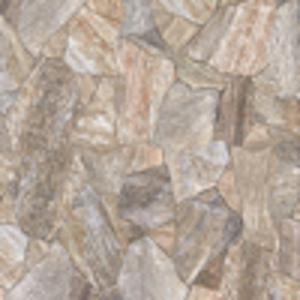

In [42]:
display(synthesized_source.resize((300, 300)))

(100, 100)
(300, 300)
size: (300, 300)  window size: 5x5
boundary num: 400 i: 0


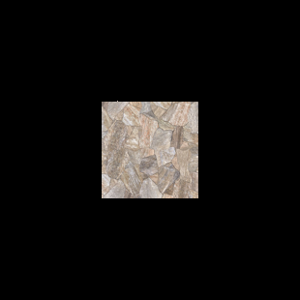

i: 0 processs: 11.1%
boundary num: 404 i: 400
boundary num: 408 i: 804
boundary num: 412 i: 1212
boundary num: 416 i: 1624
boundary num: 420 i: 2040
boundary num: 424 i: 2460
boundary num: 428 i: 2884
boundary num: 432 i: 3312
boundary num: 436 i: 3744
boundary num: 440 i: 4180
boundary num: 444 i: 4620
boundary num: 448 i: 5064
boundary num: 452 i: 5512
boundary num: 456 i: 5964
boundary num: 460 i: 6420
boundary num: 464 i: 6880
boundary num: 468 i: 7344
boundary num: 472 i: 7812
boundary num: 476 i: 8284
boundary num: 480 i: 8760
boundary num: 484 i: 9240
boundary num: 488 i: 9724


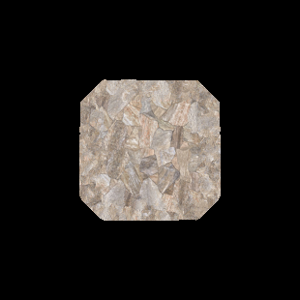

i: 10000 processs: 22.2%
boundary num: 492 i: 10212
boundary num: 496 i: 10704
boundary num: 500 i: 11200
boundary num: 504 i: 11700
boundary num: 508 i: 12204
boundary num: 512 i: 12712
boundary num: 516 i: 13224
boundary num: 520 i: 13740
boundary num: 524 i: 14260
boundary num: 528 i: 14784
boundary num: 532 i: 15312
boundary num: 536 i: 15844
boundary num: 540 i: 16380
boundary num: 544 i: 16920
boundary num: 548 i: 17464
boundary num: 552 i: 18012
boundary num: 556 i: 18564
boundary num: 560 i: 19120
boundary num: 564 i: 19680


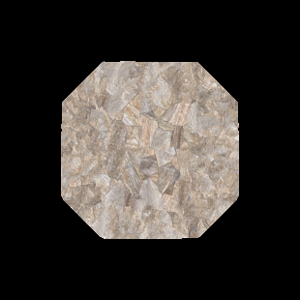

i: 20000 processs: 33.3%
boundary num: 568 i: 20244
boundary num: 572 i: 20812
boundary num: 576 i: 21384
boundary num: 580 i: 21960
boundary num: 584 i: 22540
boundary num: 588 i: 23124
boundary num: 592 i: 23712
boundary num: 596 i: 24304
boundary num: 600 i: 24900
boundary num: 604 i: 25500
boundary num: 608 i: 26104
boundary num: 612 i: 26712
boundary num: 616 i: 27324
boundary num: 620 i: 27940
boundary num: 624 i: 28560
boundary num: 628 i: 29184
boundary num: 632 i: 29812


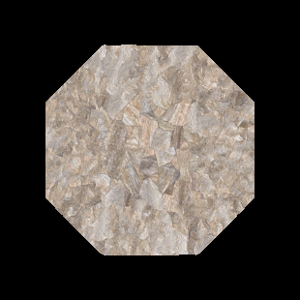

i: 30000 processs: 44.4%
boundary num: 636 i: 30444
boundary num: 640 i: 31080
boundary num: 644 i: 31720
boundary num: 648 i: 32364
boundary num: 652 i: 33012
boundary num: 656 i: 33664
boundary num: 660 i: 34320
boundary num: 664 i: 34980
boundary num: 668 i: 35644
boundary num: 672 i: 36312
boundary num: 676 i: 36984
boundary num: 680 i: 37660
boundary num: 684 i: 38340
boundary num: 688 i: 39024
boundary num: 692 i: 39712


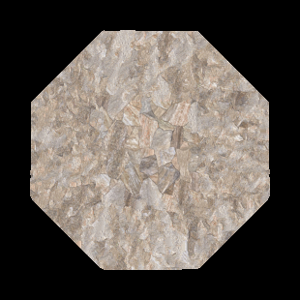

i: 40000 processs: 55.6%
boundary num: 696 i: 40404
boundary num: 700 i: 41100
boundary num: 704 i: 41800
boundary num: 708 i: 42504
boundary num: 712 i: 43212
boundary num: 716 i: 43924
boundary num: 720 i: 44640
boundary num: 724 i: 45360
boundary num: 728 i: 46084
boundary num: 732 i: 46812
boundary num: 736 i: 47544
boundary num: 740 i: 48280
boundary num: 744 i: 49020
boundary num: 748 i: 49764


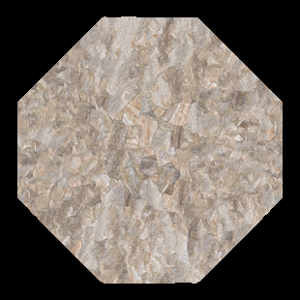

i: 50000 processs: 66.7%
boundary num: 752 i: 50512
boundary num: 756 i: 51264
boundary num: 760 i: 52020
boundary num: 764 i: 52780
boundary num: 768 i: 53544
boundary num: 772 i: 54312
boundary num: 776 i: 55084
boundary num: 580 i: 55860
boundary num: 580 i: 56440
boundary num: 580 i: 57020
boundary num: 580 i: 57600
boundary num: 580 i: 58180
boundary num: 580 i: 58760
boundary num: 580 i: 59340
boundary num: 580 i: 59920


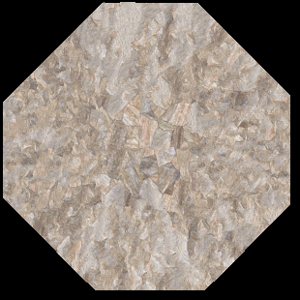

i: 60000 processs: 77.8%
boundary num: 580 i: 60500
boundary num: 580 i: 61080
boundary num: 380 i: 61660
boundary num: 376 i: 62040
boundary num: 372 i: 62416
boundary num: 368 i: 62788
boundary num: 364 i: 63156
boundary num: 360 i: 63520
boundary num: 356 i: 63880
boundary num: 352 i: 64236
boundary num: 348 i: 64588
boundary num: 344 i: 64936
boundary num: 340 i: 65280
boundary num: 336 i: 65620
boundary num: 332 i: 65956
boundary num: 328 i: 66288
boundary num: 324 i: 66616
boundary num: 320 i: 66940
boundary num: 316 i: 67260
boundary num: 312 i: 67576
boundary num: 308 i: 67888
boundary num: 304 i: 68196
boundary num: 300 i: 68500
boundary num: 296 i: 68800
boundary num: 292 i: 69096
boundary num: 288 i: 69388
boundary num: 284 i: 69676
boundary num: 280 i: 69960


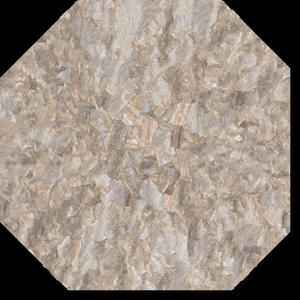

i: 70000 processs: 88.9%
boundary num: 276 i: 70240
boundary num: 272 i: 70516
boundary num: 268 i: 70788
boundary num: 264 i: 71056
boundary num: 260 i: 71320
boundary num: 256 i: 71580
boundary num: 252 i: 71836
boundary num: 248 i: 72088
boundary num: 244 i: 72336
boundary num: 240 i: 72580
boundary num: 236 i: 72820
boundary num: 232 i: 73056
boundary num: 228 i: 73288
boundary num: 224 i: 73516
boundary num: 220 i: 73740
boundary num: 216 i: 73960
boundary num: 212 i: 74176
boundary num: 208 i: 74388
boundary num: 204 i: 74596
boundary num: 200 i: 74800
boundary num: 196 i: 75000
boundary num: 192 i: 75196
boundary num: 188 i: 75388
boundary num: 184 i: 75576
boundary num: 180 i: 75760
boundary num: 176 i: 75940
boundary num: 172 i: 76116
boundary num: 168 i: 76288
boundary num: 164 i: 76456
boundary num: 160 i: 76620
boundary num: 156 i: 76780
boundary num: 152 i: 76936
boundary num: 148 i: 77088
boundary num: 144 i: 77236
boundary num: 140 i: 77380
boundary num: 136 i: 77520
bou

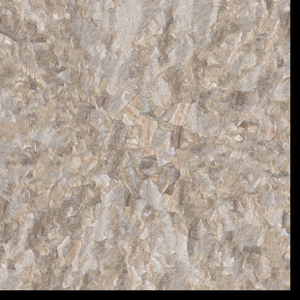

saved at: /content/drive/MyDrive/synthesized_texture_floor_random1_sigma1.5.jpg


In [43]:
synthesized_texture = texture_synthesis(
    synthesized_source,
    synthesized_source_size,
    window_size,
    max_iterations=9999999,
    sigma=1.5,
    num_of_RandomSelect=1
)

output_path = '/content/drive/MyDrive/synthesized_texture_floor_random1_sigma1.5.jpg'
synthesized_texture.save(output_path)
print(f"saved at: {output_path}")